# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

DIR_NAME = '/datasets/faces/final_files/'
RANDOM_STATE = 42

labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=DIR_NAME,
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=RANDOM_STATE)

Found 7591 validated image filenames.


In [2]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


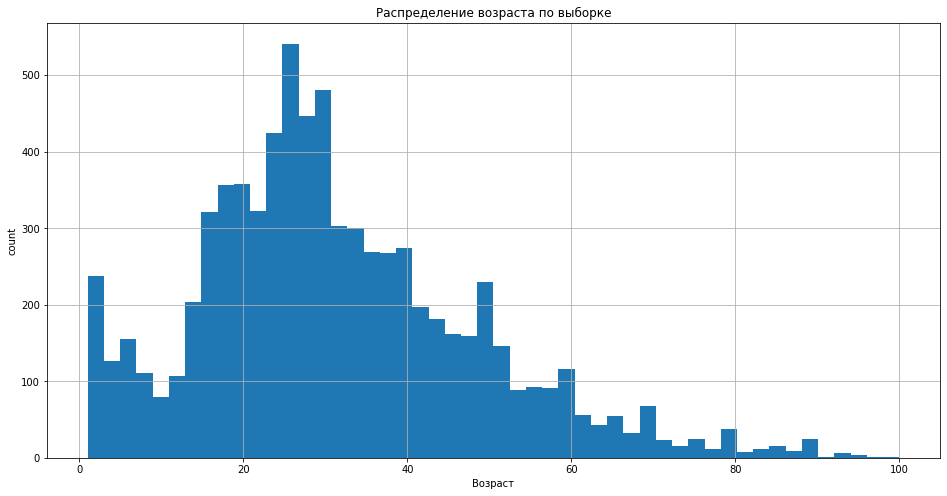

In [6]:
# Построим гистограмму:
labels['real_age'].hist(bins=50, figsize=(16, 8))
plt.title("Распределение возраста по выборке")
plt.xlabel("Возраст")
plt.ylabel("count")
plt.show()

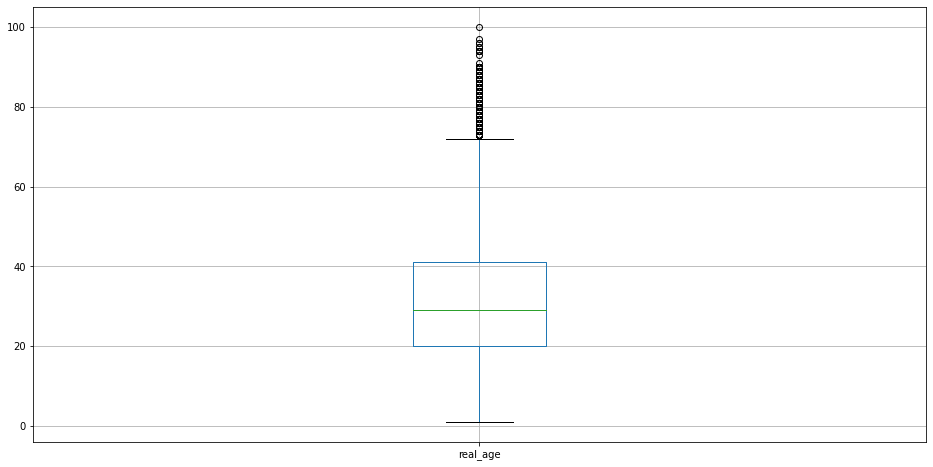

In [7]:
# Ради интереса выведем боксплот и оценим выбросы:
labels.boxplot(column=['real_age'], figsize=(16, 8))
plt.show()

In [8]:
# напишем функцию для расчета квартилей, медианы и границ выбросов
def outliers_iqr(ys):  # Передаем на вход признак-столбец датафрейма
    """
    функция считает квартили, медиану и границ выбросов
    """
    # Находим необходимые параметры
    median = ys.median()
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    print('Медиана: {},'.format(median), '25-й перцентиль: {},'.format(quartile_1), '75-й перцентиль: {},'.format(
        quartile_3), "IQR: {}, ".format(iqr), "Границы выбросов: [{}, {}].".format(lower_bound, upper_bound))
    # На выход отдаем отфильтрованные значения
    return ys.mask((ys > upper_bound) | (ys < lower_bound))

In [9]:
# посчитаем квартили, медиану и границы выбросов для 'real_age'
total_area_outliners_free = outliers_iqr(labels['real_age'])

Медиана: 29.0, 25-й перцентиль: 20.0, 75-й перцентиль: 41.0, IQR: 21.0,  Границы выбросов: [-11.5, 72.5].


In [13]:
# Посмотрим, сколько у нас значений больше в возрастной категории после 72:
# как видно, местами имеем единичные образцы, что не есть хорошо для обучения модели.
# но так как мы будет использовать уже предобученную сеть  ResNEt - вся надежда, 
# что эта сеть уже умеет работать с возрастными группами разными.
labels.query('real_age > 72').groupby(by='real_age').count()

,file_name
real_age,
73,10
74,6
75,17
76,7
77,8
78,3
79,6
80,31
81,3


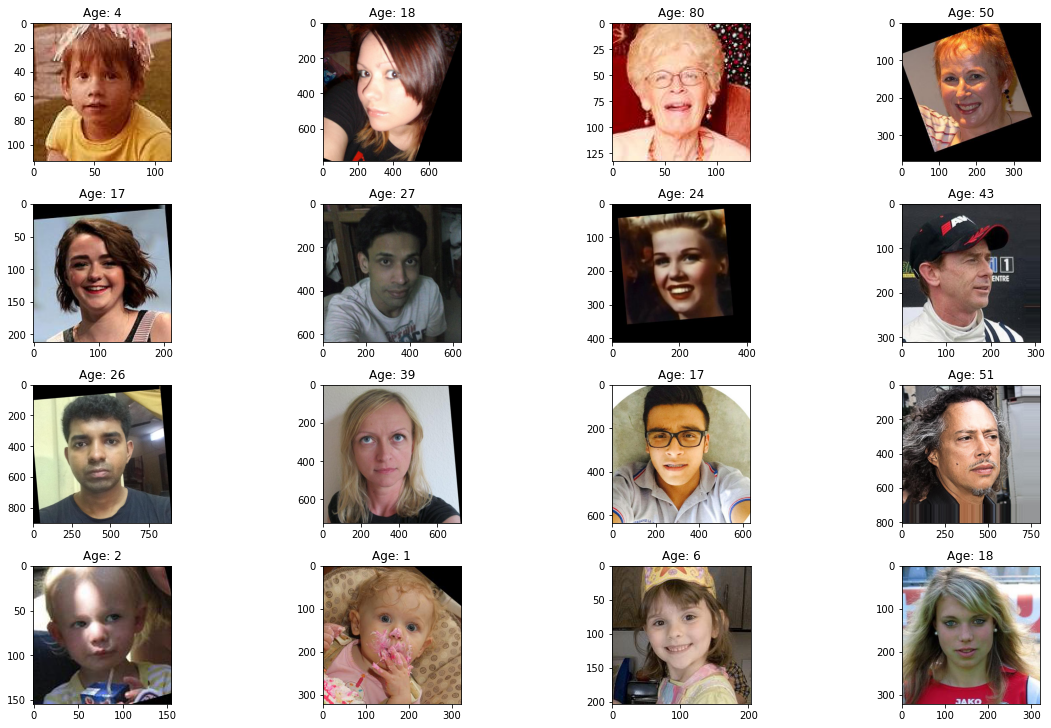

In [12]:
# Посмотрим на сами фотографии:
shape = (4, 4)
fig, ax = plt.subplots(*shape, figsize=(16, 10), constrained_layout=True)

for column_number, column in enumerate(ax):
    for row_number, row in enumerate(column):
        image_loc = column_number * shape[1] + row_number
        data = labels.iloc[image_loc]
        fname = DIR_NAME + data['file_name']
        row.imshow(Image.open(fname))
        row.set_title('Age: ' + str(data['real_age']))

plt.show()

Датасет кривоват. Помимо того, что ряд фотографий повернуты (по хорошему, сперва выровнять их), лица не всегда смотрят в одном направлении. На втором фото второго ряда явно проблемы с тенями, могут быть проблемы с определением лица, в то же время на третьем фото первого ряда явный пересвет. По хорошему тут нужно несколько этапов предварительной обработки, чтобы более качественно определять возраст. Само лицо на изображениях может занимать разную площать (хотя тут, можно считать их сопоставимыми). Также на 4м фото в третьем ряду есть артефакты, скорее всего будут проблемы с определением. А детские фотографии кроме лица содержать дополнительные элементы, что также могут нам помешать.

Промежуточные выводы:
В возрастных данных Real_age есть выбросы, но это не критично. Более опасно, что у нас в отдельных группах возрастов мало примеров для обучения сети. Возможно стоило бы использовать другой датасет или ограничить возрастные группы для обучения. Однако, мы надеемся на "мудрость" ResNet и умение определять возраст:)

Датасет не идеален: Размер фото примерно одинаков, в целом фото ориентированы правильно (нет необходимости переворота), цветность - у всех цветные; однако ряд фотографий повернуты под углом 30-45'(надо бы выровнять их); лица не всегда смотрят в одном направлении. На некоторых  фото  явно проблемы с тенями (могут быть проблемы с определением лица), в то же время на третьем фото первого ряда явный пересвет. На некоторых лицах есть полосы света\тени - что тоже может затруднять определение лица и возраста. Площадь лица в датасете  можно считать  эквивалетными. В датасете есть лица детей, которые часто прикрывают лицо руками или постороними предметами (может быть бутылочка) - это тоже затрудняет работу модели.
В идеале тут нужно несколько этапов предварительной обработки, чтобы модель могла более качественно определять лицо и возраст. Возможно некоторые образцы стоит просто удалить (или даже отдельные возрастные группы). 
Мы же будем строить модель с минимальными обработками датасета.
Надеемся что  ResNet легко с этим всем справится.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

Мы построили сверточную нейронную сеть на базе предобученной сети ResNet50. Так как сеть ResNet50 - очень хорошо обучена на картинках людей, то для достижения удовлетворительного результата по ТЗ мы добавили всего несколько слоев, используем GlobalAveragePooling2D пулинг для уменьшения кол-ва параметров модели, алгоритм оптимизации - взяли  Adam. Как показала практика - достаточно всего 10 эпох обучения.
Для оценки модели мы используем метрику MAE (т.е. имеем дело с регрессией).

In [ ]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

2022-08-28 06:57:49.275443: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-08-28 06:57:49.277083: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2022-08-28 06:57:50.100078: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-08-28 06:57:50.109584: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-28 06:57:50.109643: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-08-28 06:57:50.109674: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-28 06:57:50.111383: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-08-28 06:57:50.111719: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-08-28 06:57:50.113608: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-08-28 06:57:50.114707: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-08-28 06:57:50.114762: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-08-28 06:57:50.118241: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-08-28 06:57:50.285339: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-08-28 06:57:50.291341: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2022-08-28 06:57:50.291715: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4f07050 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-08-28 06:57:50.291743: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-08-28 06:57:50.433728: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4de4cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-08-28 06:57:50.433765: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-08-28 06:57:50.435799: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-28 06:57:50.435862: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-08-28 06:57:50.435873: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-28 06:57:50.435903: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-08-28 06:57:50.435914: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-08-28 06:57:50.435925: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-08-28 06:57:50.435936: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-08-28 06:57:50.435943: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-08-28 06:57:50.439650: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-08-28 06:57:50.439717: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-08-28 06:57:50.752913: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-08-28 06:57:50.752965: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-08-28 06:57:50.752973: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-08-28 06:57:50.756789: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-08-28 06:57:50.756838: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 6s
   81920/94765736 [..............................] - ETA: 1:04
  212992/94765736 [..............................] - ETA: 47s 
  540672/94765736 [..............................] - ETA: 27s
 1392640/94765736 [..............................] - ETA: 13s
 3522560/94765736 [>.............................] - ETA: 6s 
 7569408/94765736 [=>............................] - ETA: 3s
11829248/94765736 [==>...........................] - ETA: 2s
12591104/94765736 [==>...........................] - ETA: 3s
16719872/94765736 [====>.........................] - ETA: 2s
16785408/94765736 [====>.........................] - ETA: 3s
20914176/94765736 [=====>........................] - ETA: 2s
20979712/94765736 [=====>........................] - ETA: 2s
25108480/94765736 [======>.......................] - ETA: 2s
25174016/94765736 [======>.......................] - ETA: 2s
29302784/94765736 [========>.....................] - ETA: 2s
29368320/94765736 [========>.....................] - ETA: 2s
33497088/94765736 [=========>....................] - ETA: 2s
33562624/94765736 [=========>....................] - ETA: 2s
37691392/94765736 [==========>...................] - ETA: 2s
37756928/94765736 [==========>...................] - ETA: 2s
41885696/94765736 [============>.................] - ETA: 2s
41951232/94765736 [============>.................] - ETA: 2s
46080000/94765736 [=============>................] - ETA: 1s
46145536/94765736 [=============>................] - ETA: 2s
50274304/94765736 [==============>...............] - ETA: 1s
50339840/94765736 [==============>...............] - ETA: 1s
54468608/94765736 [================>.............] - ETA: 1s
54534144/94765736 [================>.............] - ETA: 1s
58662912/94765736 [=================>............] - ETA: 1s
58728448/94765736 [=================>............] - ETA: 1s
62857216/94765736 [==================>...........] - ETA: 1s
62922752/94765736 [==================>...........] - ETA: 1s
67051520/94765736 [====================>.........] - ETA: 1s
67117056/94765736 [====================>.........] - ETA: 1s
70017024/94765736 [=====================>........] - ETA: 1s
71311360/94765736 [=====================>........] - ETA: 0s
74211328/94765736 [======================>.......] - ETA: 0s
75505664/94765736 [======================>.......] - ETA: 0s
78405632/94765736 [=======================>......] - ETA: 0s
79699968/94765736 [========================>.....] - ETA: 0s
82599936/94765736 [=========================>....] - ETA: 0s
82944000/94765736 [=========================>....] - ETA: 0s
83894272/94765736 [=========================>....] - ETA: 0s
85303296/94765736 [==========================>...] - ETA: 0s
86728704/94765736 [==========================>...] - ETA: 0s
88039424/94765736 [==========================>...] - ETA: 0s
89497600/94765736 [===========================>..] - ETA: 0s
90923008/94765736 [===========================>..] - ETA: 0s
92282880/94765736 [============================>.] - ETA: 0s
93691904/94765736 [============================>.] - ETA: 0s
94773248/94765736 [==============================] - 4s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/10
2022-08-28 06:58:06.590106: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-28 06:58:06.876783: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 50s - loss: 195.6973 - mae: 10.1783 - val_loss: 411.8620 - val_mae: 15.1782
Epoch 2/10
356/356 - 41s - loss: 83.3118 - mae: 6.9040 - val_loss: 139.1417 - val_mae: 8.9642
Epoch 3/10
356/356 - 41s - loss: 58.0814 - mae: 5.8237 - val_loss: 83.5708 - val_mae: 6.9369
Epoch 4/10
356/356 - 41s - loss: 44.4072 - mae: 5.1119 - val_loss: 65.7992 - val_mae: 6.0719
Epoch 5/10
356/356 - 41s - loss: 33.1441 - mae: 4.4096 - val_loss: 71.4960 - val_mae: 6.3203
Epoch 6/10
356/356 - 41s - loss: 26.1780 - mae: 3.9068 - val_loss: 77.1013 - val_mae: 6.4718
Epoch 7/10
356/356 - 41s - loss: 21.6149 - mae: 3.5247 - val_loss: 70.0845 - val_mae: 6.1496
Epoch 8/10
356/356 - 41s - loss: 17.7897 - mae: 3.2159 - val_loss: 70.8804 - val_mae: 6.3422
Epoch 9/10
356/356 - 41s - loss: 16.6805 - mae: 3.0560 - val_loss: 67.9282 - val_mae: 6.0340
Epoch 10/10
356/356 - 41s - loss: 13.0740 - mae: 2.7343 - val_loss: 64.1534 - val_mae: 5.8183
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 64.1534 - mae: 5.8183
Test MAE: 5.8183

## Анализ обученной модели

Мы построили сверточную нейронную сеть на базе предобученной сети ResNet50. Так как сеть ResNet50 - очень хорошо обучена на картинках людей, то для достижения удовлетворительного результата по ТЗ мы добавили всего несколько слоев, используем GlobalAveragePooling2D пулинг для уменьшения кол-ва параметров модели,алгоритм оптимизации - взяли  Adam. Как показала практика - достаточно всего 10 эпох обучения.  

Для оценки модели мы используем метрику MAE (т.е. имеем дело с регрессией).  

В итоге мы добились результатов  по метрике MAE = 5.82 Что есть очень хорошо.
Так что, полученная легкая и быстрая модель позволяет решать задачи бизнеса в базовом виде с допустимой точностью.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [ ]  MAE модели не больше 8
- [ ]  Код обучения модели скопирован в финальную тетрадь
- [ ]  Результат вывода модели на экран перенесён в финальную тетрадь
- [ ]  По итогам обучения модели сделаны выводы

Выводы:


ResNet50 -настолько крутая обученная нейросеть, имеющая опыт работы с разными картинками (и конечно же людьми), что нам не пришлось строить сложную сверточную нейросеть (из множества слоев и используя разные фитчи) для достижения необходимой метрики. Нам даже не понадобилась дополнительная предобработка (аугментация, удаление кривых данных и пр.), хотя и  сам датасет был вполне сносным (данные были "удобными" для распознования.  
В итоге мы добились результатов  по метрике MAE = 5.82 Что есть очень хорошо.
Так что, полученная модель позволяет решать задачи бизнеса в базовом виде. 
